# Learning symmetries
----------------------------------------

## Motivation

- Symmetries "encode" the physics of observed dynamics and content
- Can you learn symmetries from data? Early QCD experiments "learned" that N=3 for QCD, for the SU(N) gauge theory
- Perhaps initializing learning problems with physical symmetries encoded can substantially decrease training
- Also keep in mind this is why discrimination at scale can occurr with ML methods
- This example is simple enough to show how to implement a fully connected neural net

All code available at my github: richardagalvez

### Innocent start, but things got funny..
---------------------------------------------

## 1. Rotations

In this notebook, the NN learns learns the 2d rotation matrix, parameterized by the generator of rotations in two dimensions:

$R={\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \\\end{bmatrix}}$

In [20]:
num_nodes=1000
class Rotations(nn.Module):
    def __init__(self):
        super(Rotations, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(1,num_nodes,bias=True),
            nn.Sigmoid(),
            nn.Linear(num_nodes,num_nodes,bias=True),
            nn.Sigmoid(),
            nn.Linear(num_nodes,num_nodes,bias=True),
            nn.Sigmoid(),
            nn.Linear(num_nodes,2,bias=True))        
    def forward(self, x):
        out=self.layer1(x)
        return out
criterion=nn.SmoothL1Loss()

In [32]:
num_nodes=1000
class Rotations(nn.Module):
    def __init__(self):
        super(Rotations, self).__init__()
        self.input=nn.Linear(1,num_nodes,bias=True)
        self.rnn=nn.LSTM(num_nodes,num_nodes,8)
        self.out=nn.Linear(num_nodes,2,bias=True)        
    def forward(self,x,hidden):
        x=self.input(x)
        x,hidden=self.rnn(x.view(1,1,-1))
        x=self.out(x.view(-1))
        return x
criterion=nn.SmoothL1Loss()

## Training with generated data: $\theta_{train} \in [0,4\pi]$

In [39]:
models = []
optimizers = []
for k in range(1):
    models.append(Rotations())
    models[-1].apply(weight_init)
    models[-1].cuda()
    optimizers.append(torch.optim.Adam(models[-1].parameters(),lr=1.0e-3,weight_decay=1.0e-9))

In [ ]:
%%time
theta=train_models(models,circle_interval=2.,num_samples=10000)

0: %: 0.000
500: %: 5.000
1000: %: 10.000
1500: %: 15.000
2000: %: 20.000
2500: %: 25.000
3000: %: 30.000


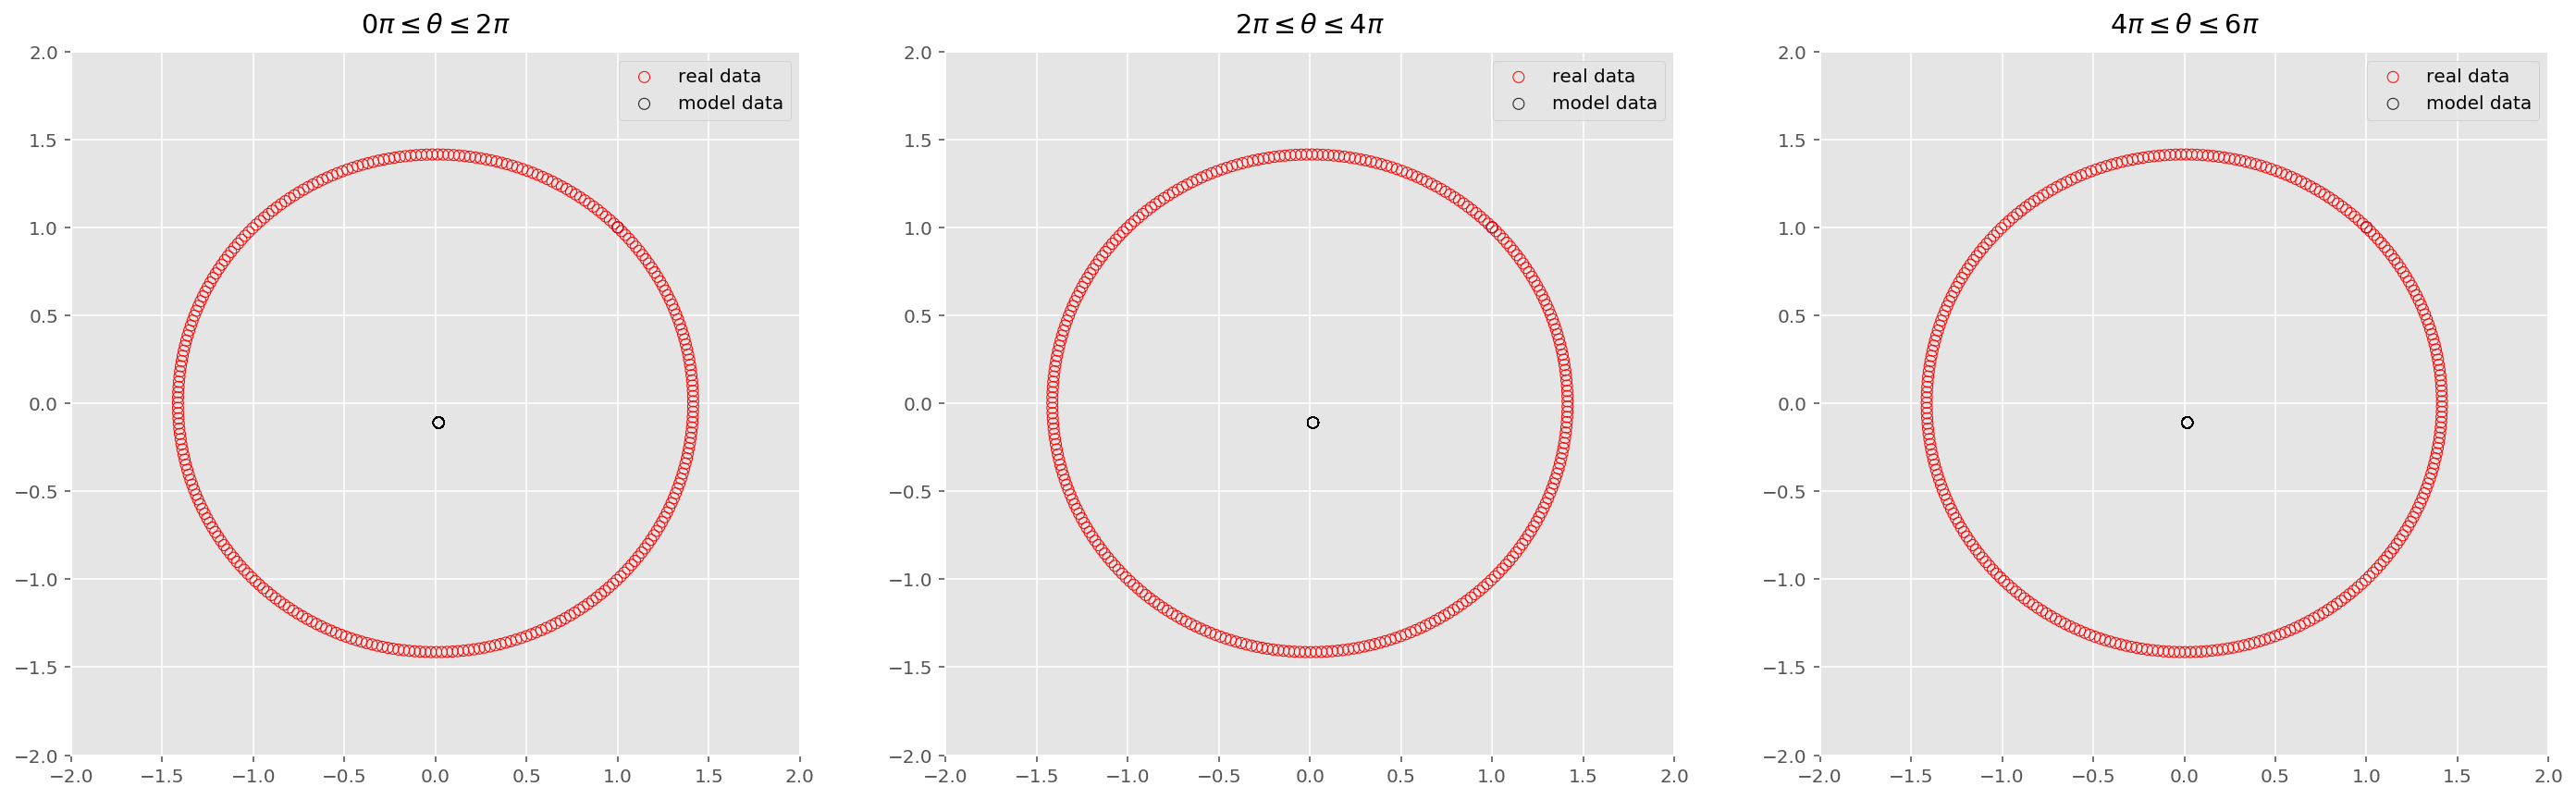

In [38]:
plot_circles(models,offset=0,CI=False)

layer 0: torch.Size([1, 1000])
layer 1: torch.Size([1000])
layer 2: torch.Size([1000, 4000])
layer 3: torch.Size([1000, 4000])
layer 4: torch.Size([4000])
layer 5: torch.Size([4000])
layer 6: torch.Size([1000, 4000])
layer 7: torch.Size([1000, 4000])
layer 8: torch.Size([4000])
layer 9: torch.Size([4000])
layer 10: torch.Size([1000, 4000])
layer 11: torch.Size([1000, 4000])
layer 12: torch.Size([4000])
layer 13: torch.Size([4000])
layer 14: torch.Size([1000, 4000])
layer 15: torch.Size([1000, 4000])
layer 16: torch.Size([4000])
layer 17: torch.Size([4000])
layer 18: torch.Size([1000, 2])
layer 19: torch.Size([2])


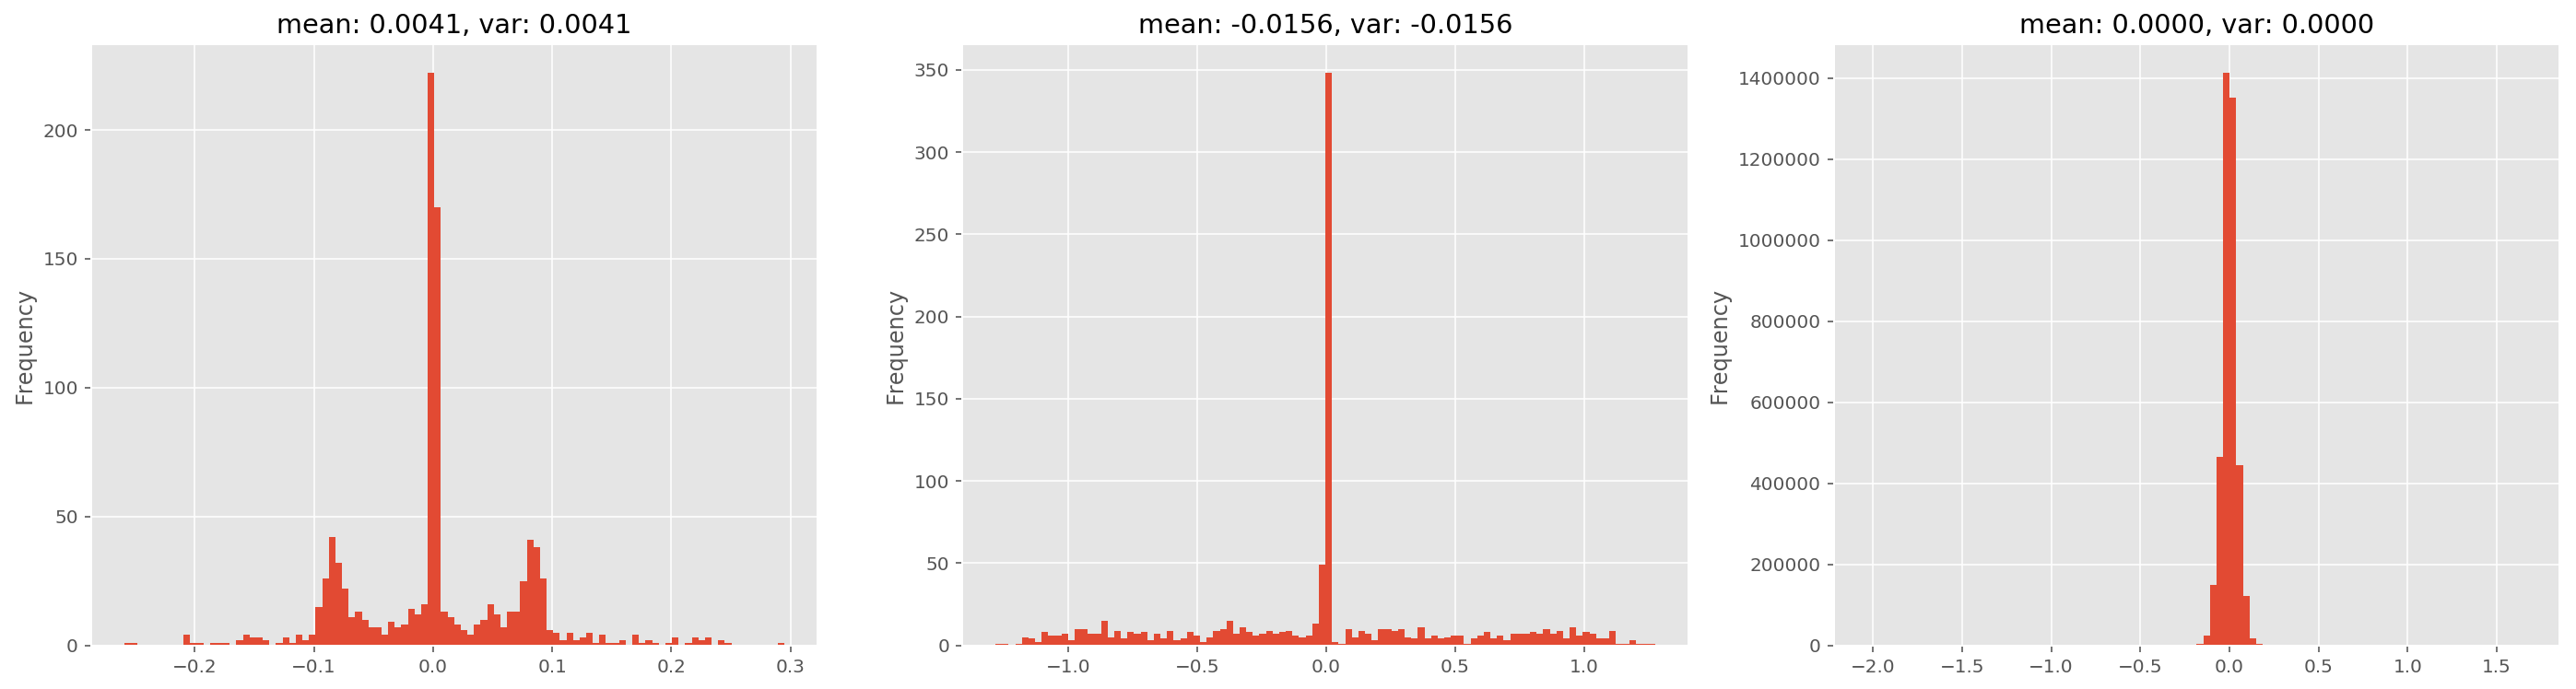

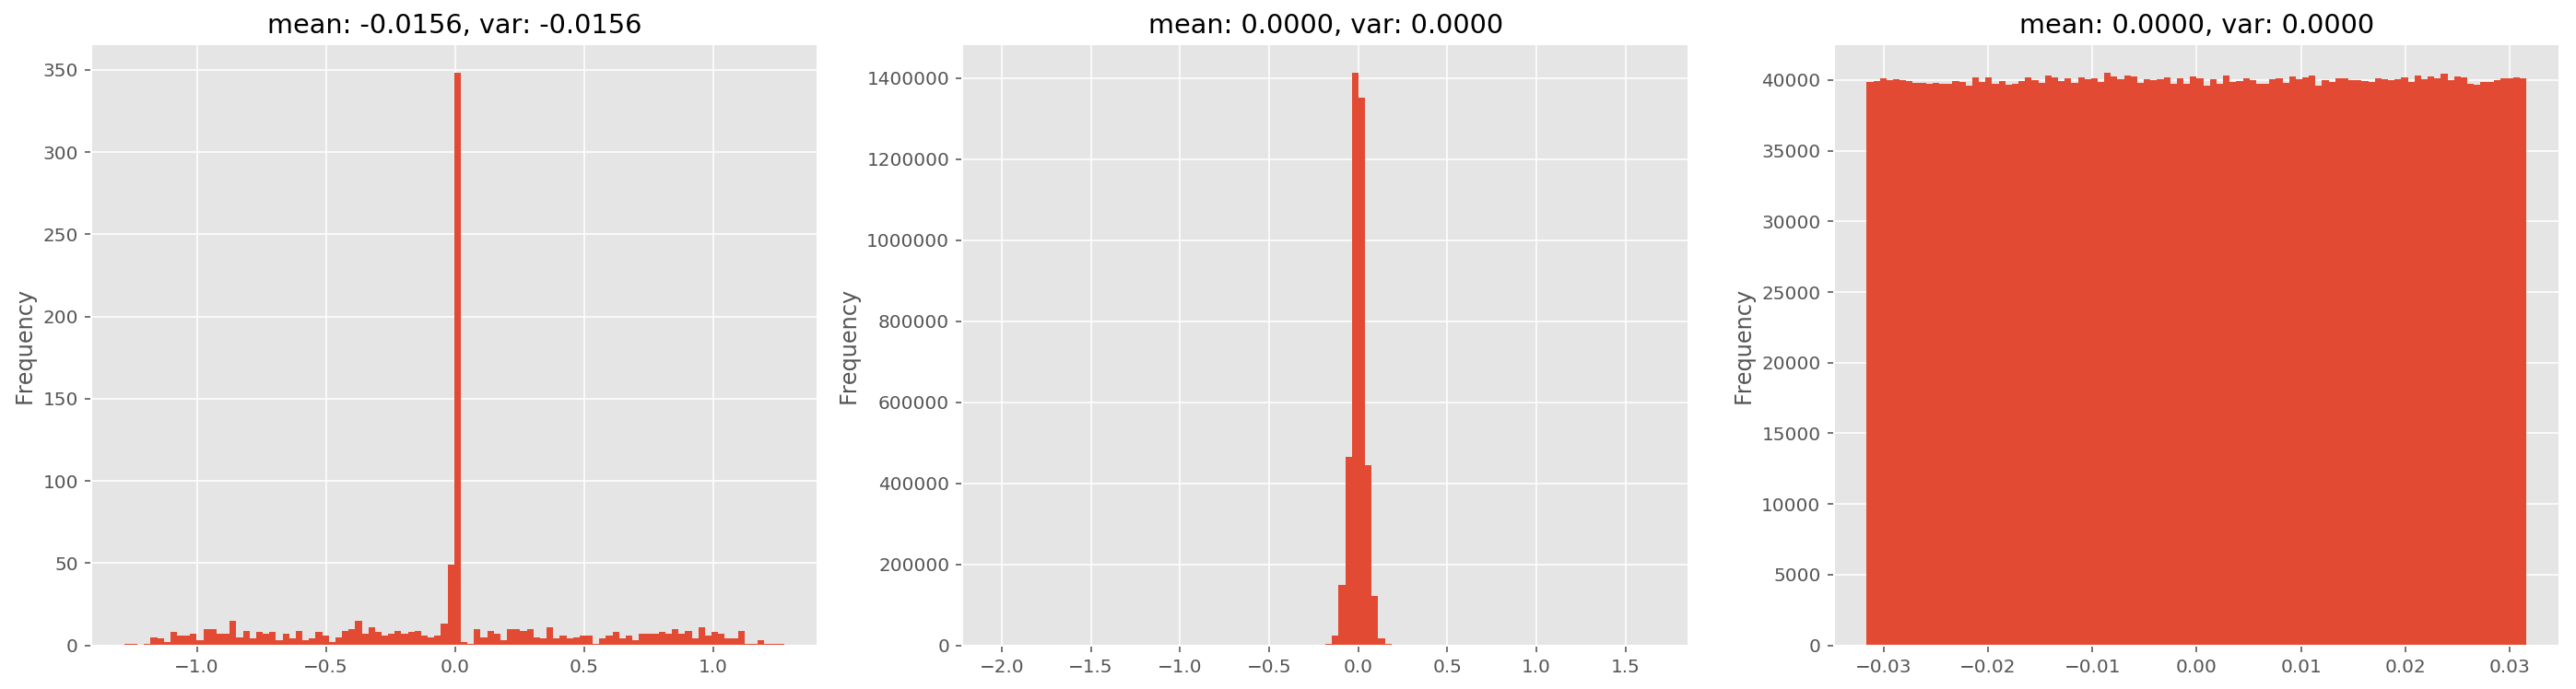

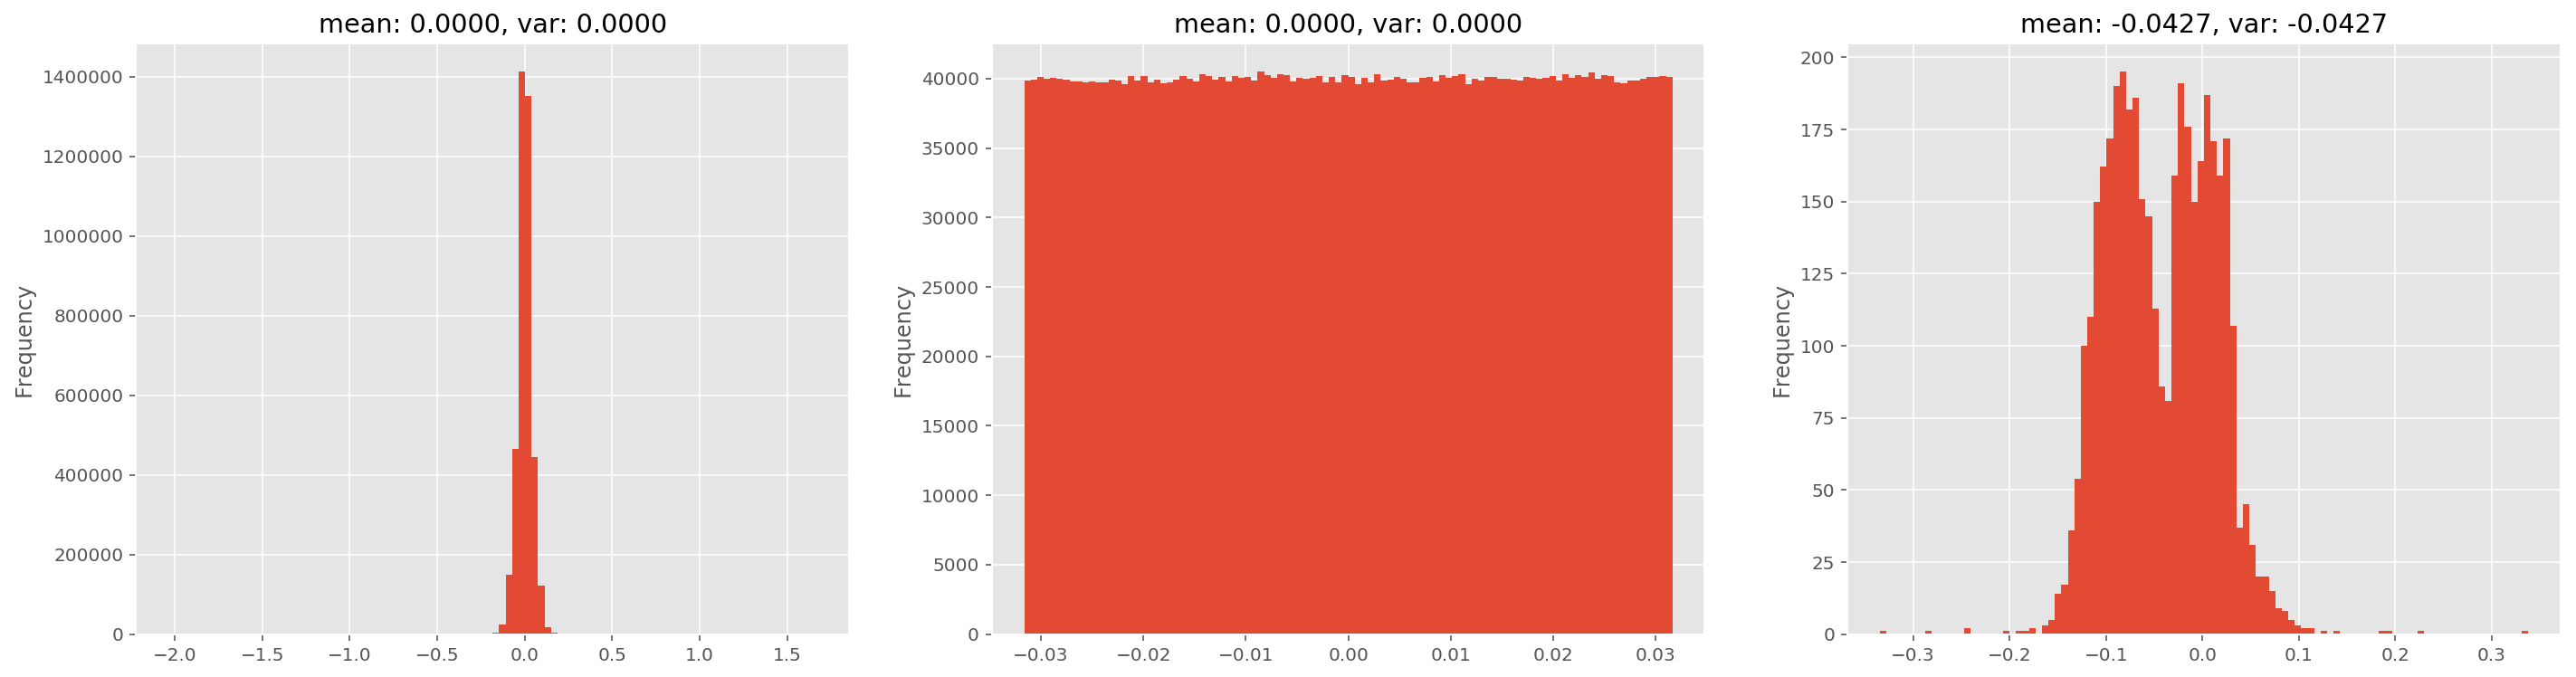

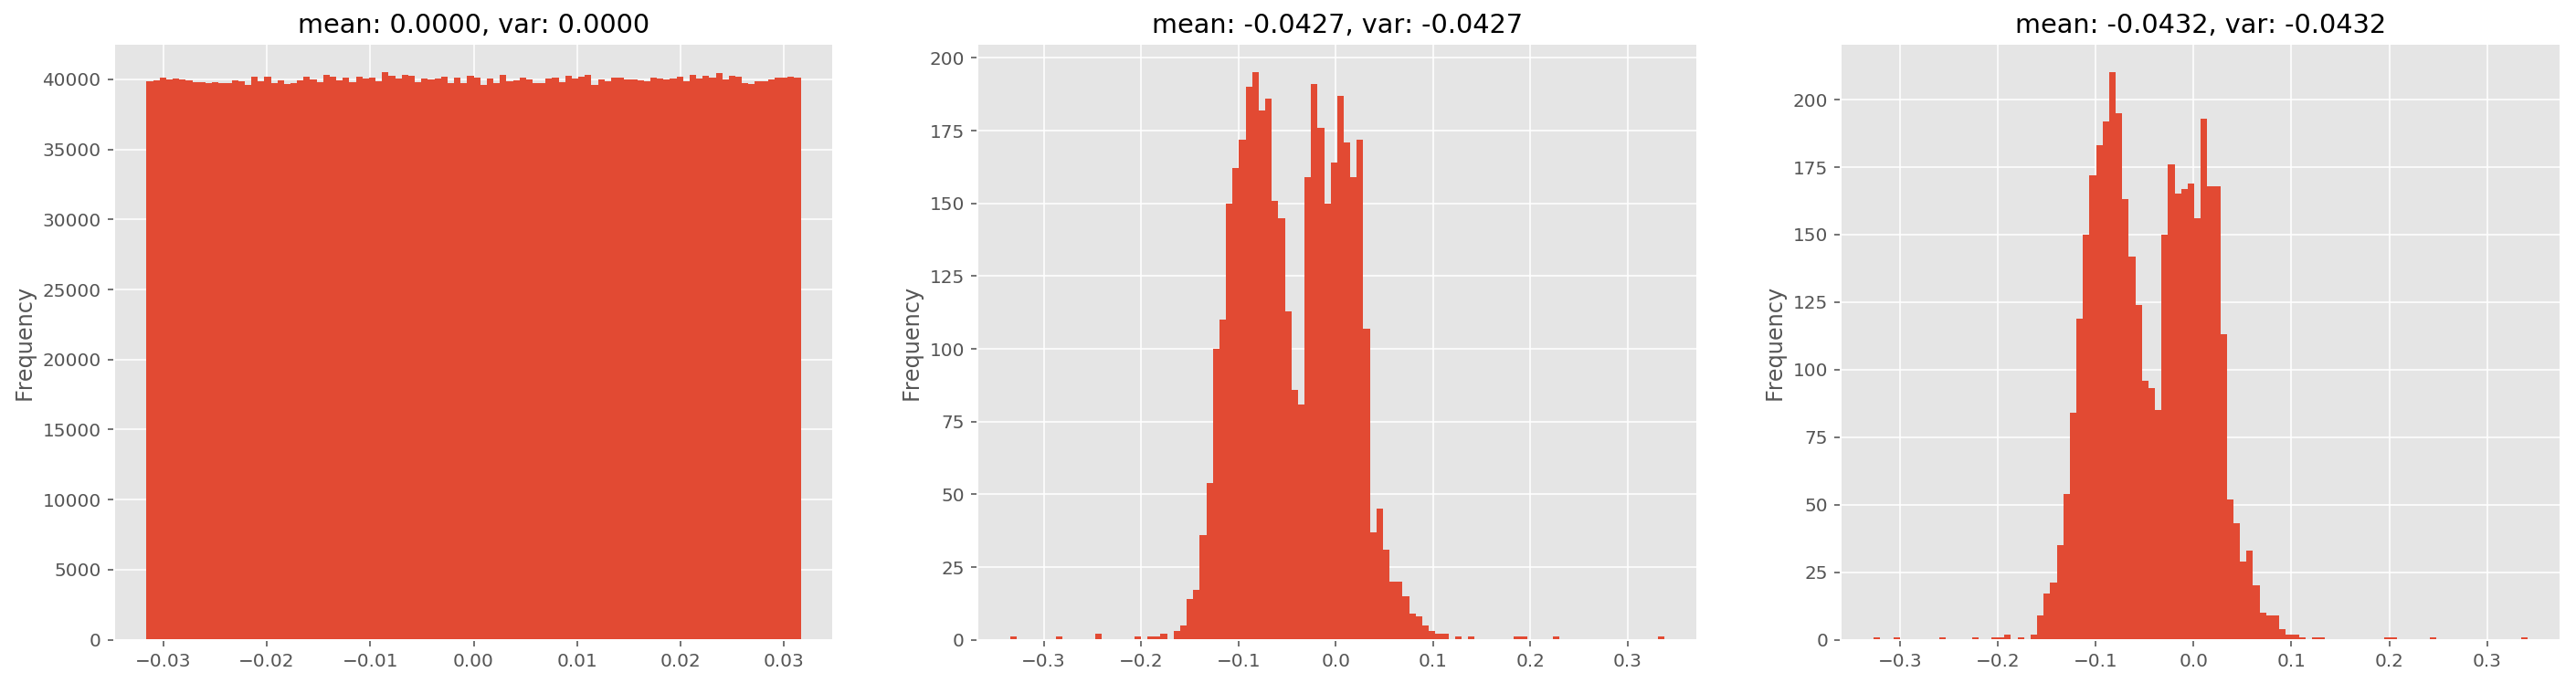

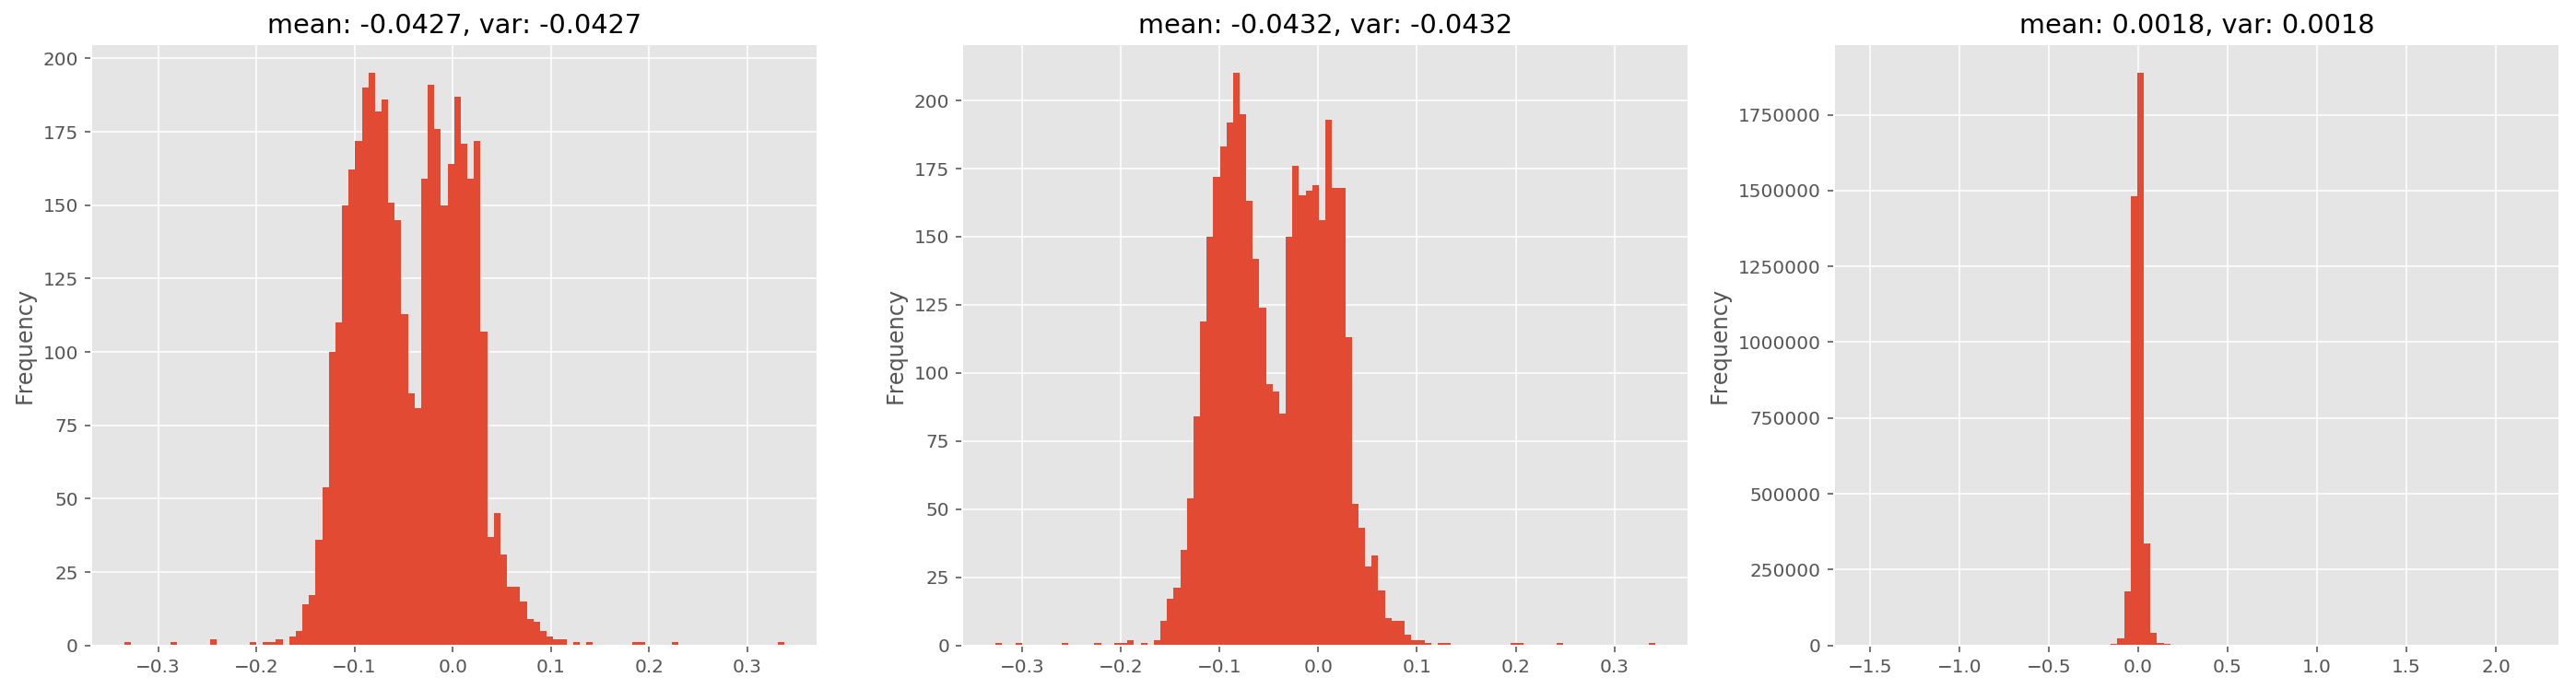

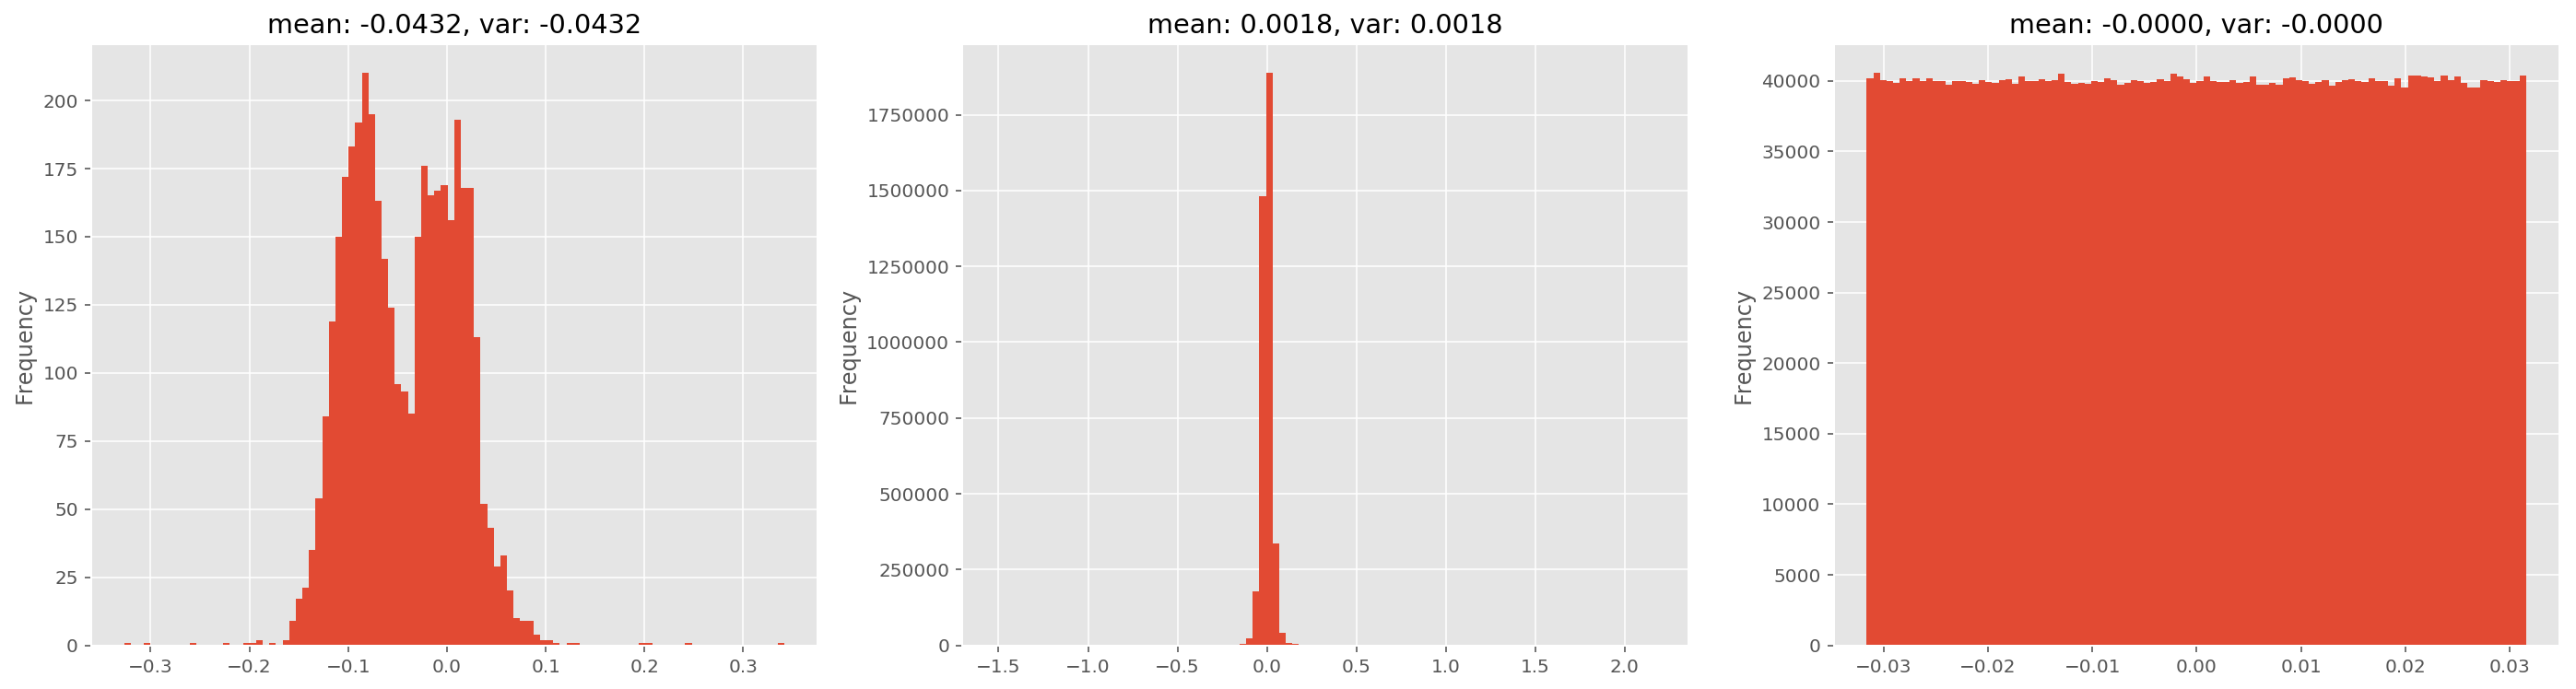

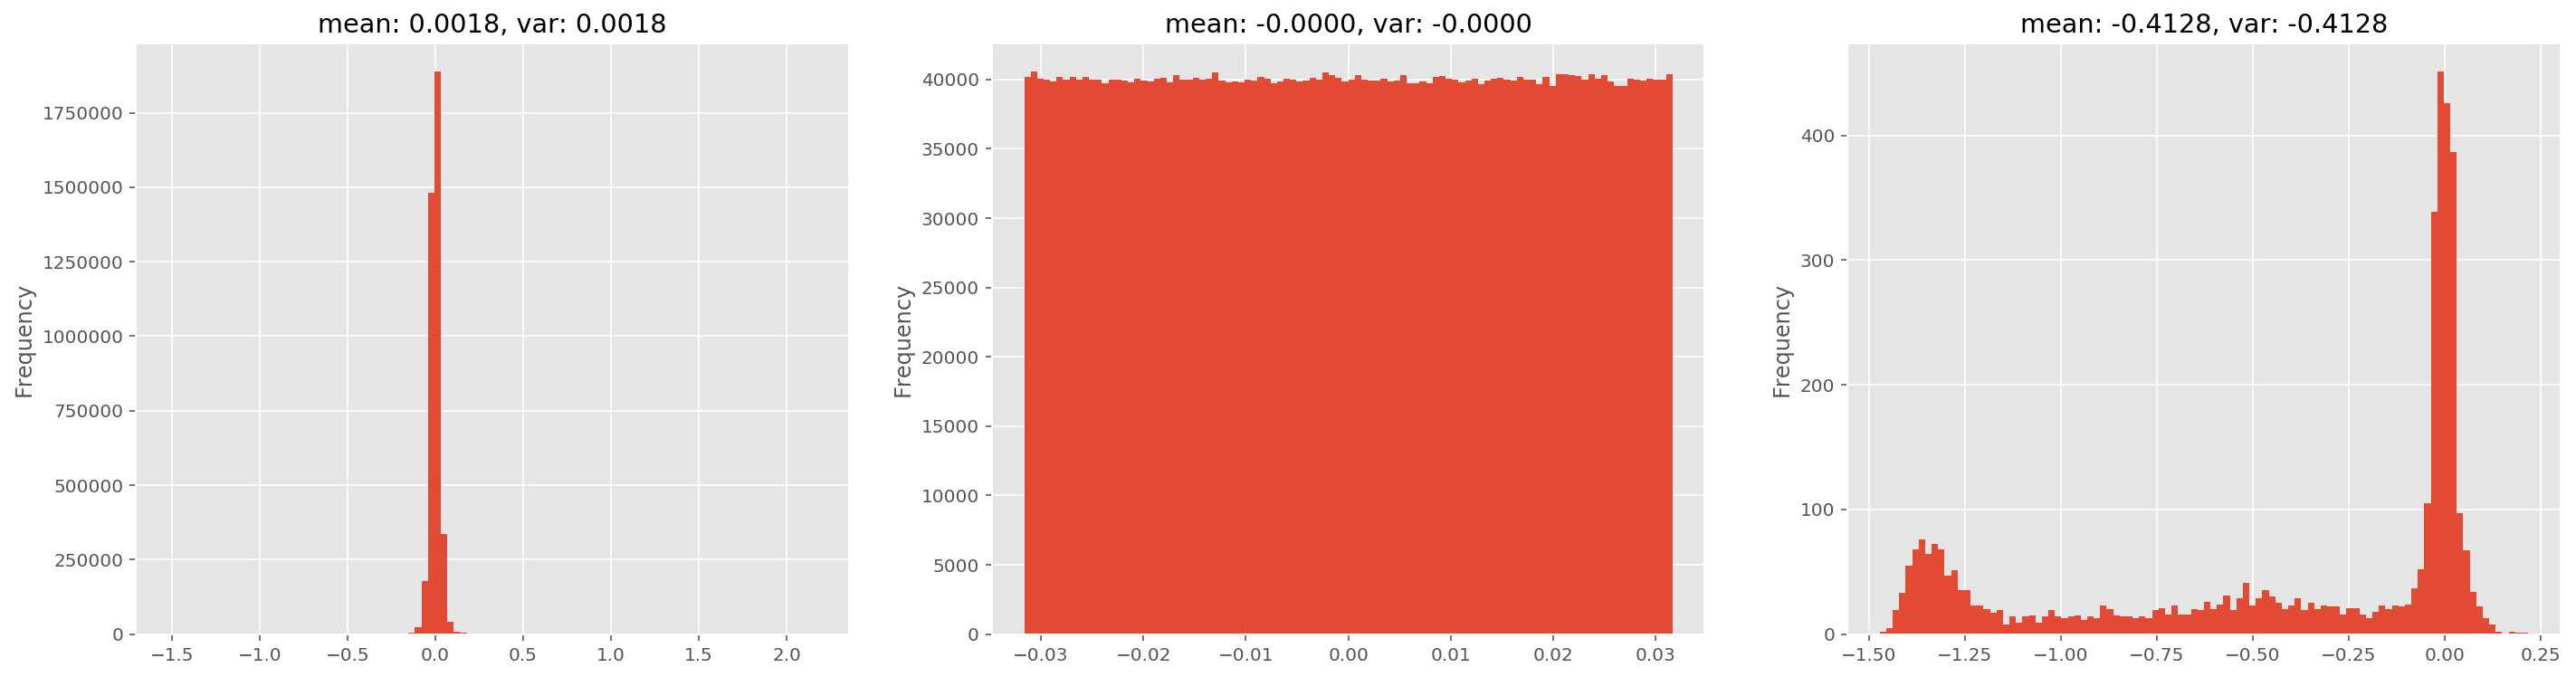

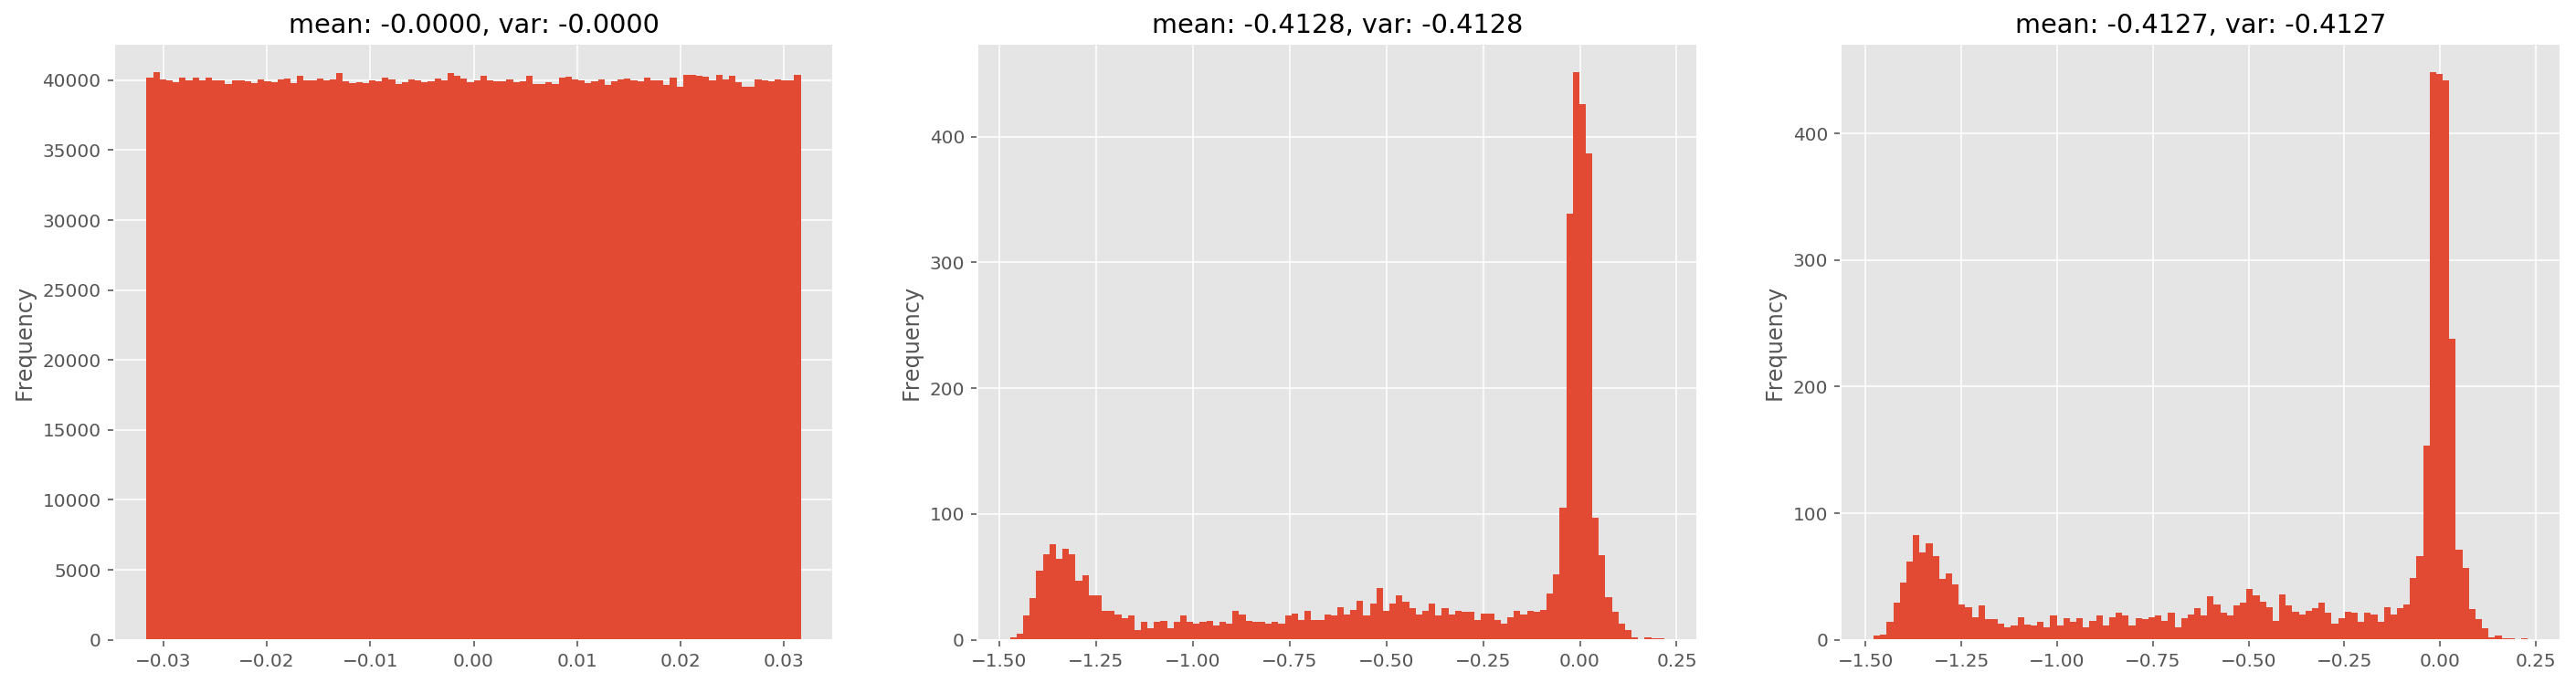

In [133]:
analyze_layer_weights(models)

# Includes, model defs, notes 

In [25]:
def train_models(models,num_samples=1000,circle_interval=1.0,save_models=False):
    for k in range(num_samples):
        # =================== progress indicator ===================
        if k % (num_samples//20) ==0:
            print('{0}: %: {1:.3f}'.format(k,k/num_samples * 100))
        # =================== data calc ===================
        x,theta=torch.ones(2),circle_interval*2*np.pi*torch.rand(1)
        R = torch.zeros(2,2)
        R[0,:]=torch.Tensor([np.cos(theta[0]),-np.sin(theta[0])])
        R[1,:]=torch.Tensor([np.sin(theta[0]), np.cos(theta[0])])
        data,target=Variable(theta).cuda(),Variable(torch.mv(R,x)).cuda()
        # =================== learning phases =================
        for l,model in enumerate(models):
            # =================== forward =====================
            output=model(data,None)
            loss=criterion(output, target)
            # =================== backward ====================
            optimizers[l].zero_grad()
            loss.backward()
            optimizers[l].step()
    # =================== save model state ====================
    if save_models:
        for l,model in enumerate(models):
            torch.save(model.state_dict(), '/scratch/rag394/data/symmetries/rotations_{}.pth'.format(l))
    return theta
        
def plot_circles(models,offset=0,CI=False):
    fig, axes = plt.subplots(figsize=(8*3,7),ncols=3)
    x = torch.ones(2)
    for k,ax in enumerate(axes):
        ax.scatter(x[0],x[1], facecolors='none', edgecolors='r')
        ax.scatter(x[0],x[1], facecolors='none', edgecolors='b')
        x_real, y_real = [],[]
        x_mean, y_mean = [],[]
        x_std, y_std = [],[]
        for theta in np.linspace((k+offset) *2*np.pi,(k+1+offset) *2*np.pi,300):
            x_model,y_model = [],[]
            # =================== sythetic (real) data ====================
            data   = Variable(torch.Tensor([theta])).cuda()
            R = torch.zeros(2,2)
            R[0,:] = torch.Tensor([np.cos(theta),-np.sin(theta)])
            R[1,:] = torch.Tensor([np.sin(theta), np.cos(theta)])
            real = torch.mv(R,x)
            x_real.append(real[0].cpu().numpy())
            y_real.append(real[1].cpu().numpy())
            # =================== predict w/ all models ====================
            for model in models:
                outputs = model(data,None).data
                xx_model, yy_model = outputs[0],outputs[1]
                x_model.append(xx_model.cpu().numpy())
                y_model.append(yy_model.cpu().numpy())
            # ============== summarize all model predictions ===============
            x_mean.append(np.mean(x_model))
            y_mean.append(np.mean(y_model))
            x_std.append(np.std(x_model))
            y_std.append(np.std(y_model))
        # ============== plotting data ===============
        ax.scatter(x_real,y_real, facecolors='none', edgecolors='r',label='real data')
        ax.scatter(x_mean,y_mean, facecolors='none', edgecolors='k',label='model data', alpha=0.9)
        if CI:
            ax.fill_betweenx(y_mean,x_mean-3*np.array(x_std),x_mean+3*np.array(x_std), alpha=0.1,color='b')
            ax.fill_between(x_mean,y_mean-3*np.array(y_std),y_mean+3*np.array(y_std), alpha=0.1,color='b')
        ax.legend()
        ax.set_ylim(-2,2)
        ax.set_xlim(-2,2)
        ax.set_title(r'${}\pi \leq \theta \leq {}\pi$'.format(2*(k+offset),2*(k+1+offset)),y=1.01);

def analyze_layer_weights(models):
    layers = []
    for k, layer in enumerate(list(models[0].parameters())):
        layers.append(layer.transpose(-1,0))
        print('layer {}: {}'.format(k,layer.transpose(-1,0).shape))

    for k in range(0,(len(layers)+6)//3):
        fig, ax = plt.subplots(figsize=(8*3,6),ncols=3)
        if k==0:
            plt.title('0.5 rotation')
        if k>len(layers):
            break
        ax[0].set_title('mean: {0:.4f}, var: {0:.4f}'.format(layers[k+0].data.cpu().numpy().flatten().mean(),layers[k+0].data.cpu().numpy().flatten().var()))
        pd.Series(layers[k+0].data.cpu().numpy().flatten()).plot(ax=ax[0],kind='hist',bins=100);
        ax[1].set_title('mean: {0:.4f}, var: {0:.4f}'.format(layers[k+1].data.cpu().numpy().flatten().mean(),layers[k+1].data.cpu().numpy().flatten().var()))
        pd.Series(layers[k+1].data.cpu().numpy().flatten()).plot(ax=ax[1],kind='hist',bins=100);
        ax[2].set_title('mean: {0:.4f}, var: {0:.4f}'.format(layers[k+2].data.cpu().numpy().flatten().mean(),layers[k+2].data.cpu().numpy().flatten().var()))
        pd.Series(layers[k+2].data.cpu().numpy().flatten()).plot(ax=ax[2],kind='hist',bins=100);
        
def weight_init(m):
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0]
        fan_in = size[1]
        variance = np.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_sequence
from torch.autograd import Variable
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## notes

In [ ]:
for k, model in enumerate(models):
    torch.save(model.state_dict(),'/scratch/rag394/data/symmetries/rotations_{}.pth'.format(k))